Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 10)                70        
                                                                 
 dense_25 (Dense)            (None, 30)                330       
                                                                 
 dense_26 (Dense)            (None, 25)                775       
                                                                 
 dense_27 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4000
2/2 [==============================] - 1s 

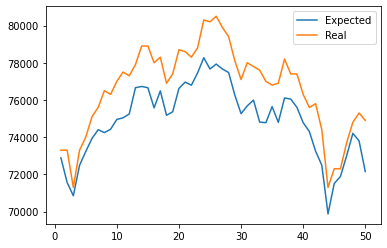

In [8]:
import pandas as pd
import google.colab.drive as drive
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler

drive.mount('/content/drive')
df = pd.read_csv('./drive/MyDrive/Colab Notebooks/data/samsung.csv')

df= pd.get_dummies(df)
df= df.fillna(df.mean())

df_corr = df.corr()
df_corr_sort = df_corr.sort_values('close', ascending=False)

df_tgt = df[['start', 'high', 'low', 'volume', 'transactionPrice', 'capitalization']]

scaler = MinMaxScaler()
scaler1 = MinMaxScaler()
scaler1.fit(df[['close']])
arr=scaler1.transform(df[['close']])
df=pd.DataFrame(arr, columns = df[['close']].columns)
scaler.fit(df_tgt)
arr=scaler.transform(df_tgt)
df1=pd.DataFrame(arr, columns = df_tgt.columns)
df=pd.concat([df,df1],axis=1)

cols_train = ['start', 'high', 'low', 'volume', 'transactionPrice', 'capitalization']

X_train_pre = df[cols_train]
y = df['close'].values

X_train, X_test, y_train, y_test = train_test_split(X_train_pre, y, test_size = 0.2, shuffle =False)

#model structure design
model = Sequential()
model.add(Dense(10, input_dim = 6, activation = 'relu'))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(1))
model.summary()

model.compile(loss= 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20)
modelpath = './drive/MyDrive/Colab Notebooks/data/model/samsung/assignment4_best_model.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor = 'val_loss', verbose = 0, save_best_only = True)

history = model.fit(X_train, y_train, epochs = 4000, batch_size = 128, validation_split = 0.25, callbacks =[early_stopping_callback, checkpointer])

real_prices = []
pred_prices = []
X_num =[]

n_iter = 0
Y_prediction = model.predict(X_test).flatten()
for i in range(len(y_test)):
  real = y_test[i]
  prediction = Y_prediction[i]
  print('Real Price: {}, Expected price : {}'.format(real, prediction))
  real_prices.append(real)
  pred_prices.append(prediction)
  n_iter = n_iter+1
  X_num.append(n_iter)

rescaled_real = scaler1.inverse_transform(np.array(real_prices).reshape(-1,1))
rescaled_pred = scaler1.inverse_transform(np.array(pred_prices).reshape(-1,1))

plt.plot(X_num, rescaled_pred, label = 'Expected')#pred_prices
plt.plot(X_num, rescaled_real, label = 'Real')#real_prices
plt.legend()
plt.show()
